# Quarto trabalho de processamento de imagens 2021.1

## Importação das bibliotecas necessárias e aquisição da imagem

In [ ]:
import cv2 # processamento de imagens
import numpy as np # funções numéricas
import matplotlib.pyplot as plt # visualização
from PIL import Image  # processamento de imagens
import requests # requisições HTTP

# Montando o google drive, onde as imagens usadas foram colocadas (mesma pasta do notebook)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


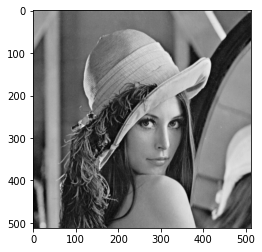

In [ ]:
def url_to_image(url):
  """
  Faz o download da imagem, converte em np.array e abre usando o OpenCV
  """
  resp = requests.get(url, stream=True)
  image = Image.open(resp.raw)

  return image

# img = np.array(url_to_image("https://www.momondo.com.br/discover/wp-content/uploads/sites/282/2016/03/0c717a77-1732-3160-bb3d-fe386d11e415.jpg"))
# img = np.array(url_to_image("https://images.unsplash.com/photo-1541685277678-972a425701ba?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxleHBsb3JlLWZlZWR8MzF8fHxlbnwwfHx8fA%3D%3D&w=1000&q=80"))
img = np.array(url_to_image("https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png"))
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

plt.imshow(img, cmap = "gray");

## Implementação do algoritmo de limiarização global

<Figure size 2160x432 with 0 Axes>

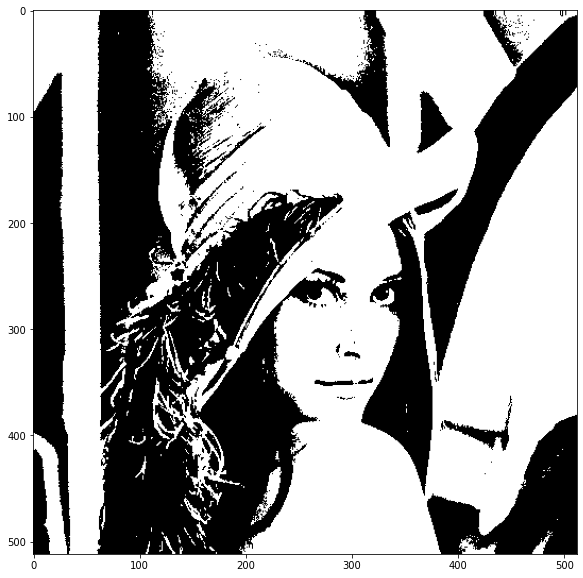

In [ ]:
def global_thresholding(img, delta_t = 0.5):

  t = img.mean()

  plt.figure(figsize = (30,6))
  
  new_t = t
  while True:
    # verificar quais os pixels maiores que a média
    thres_mask_upper = np.uint(img > new_t)

    # verificar quais os pixels menores que a média
    thres_mask_lower = np.uint(img <= new_t)

    # criar as novas imagens multiplicando as duas máscaras
    thres_img_upper = thres_mask_upper*img
    thres_img_lower = thres_mask_lower*img

    # calcular os valores médios dos pixels de ambas as imagens
    t_upper = thres_img_upper[thres_img_upper != 0].mean()
    t_lower = thres_img_lower[thres_img_lower != 0].mean()

    # armazenar o valor de t atual
    old_t = new_t
    # calcular o novo valor de t
    new_t = (t_upper + t_lower)*0.5

    # se a diferença entre os valores antigo e novo for menor que delta_t, retorna a imagem segmentada
    if np.abs(new_t - old_t) < delta_t:
      return np.where(thres_img_upper, 1, 0)
    
  return 0

thres_image = global_thresholding(img, delta_t = 0.2)
plt.figure(figsize = (10,10))
plt.imshow(thres_image, cmap = "gray");

## Método de Otsu

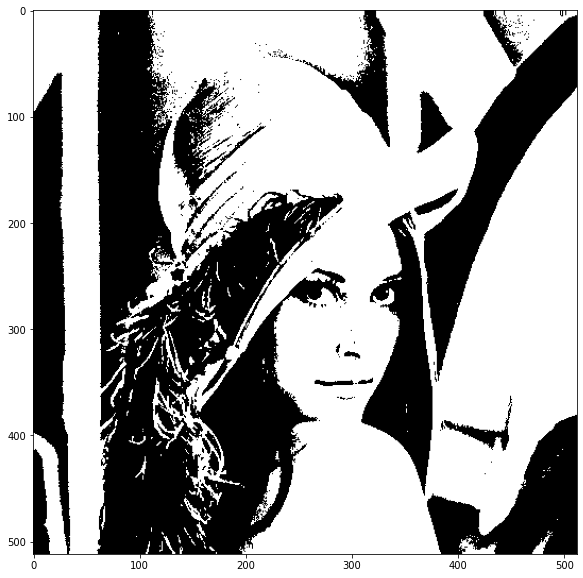

In [ ]:
thres, otsu_img = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.figure(figsize = (10,10))
plt.imshow(otsu_img, cmap = "gray")

O resultado da binarização pelo método de otsu foi bem parecido com o método de limiarização global implementado anteriormente.

## Especificação de histograma

In [ ]:
def find_nearest(array, value):
    """
    Função para achar o valor mais próximo. Muitas vezes o array de uma transformação é [0,0,0,1,1,2,3]
    e escolhemos, por convenção, o primeiro número que aparece na sequência. E.g: queremos a primeira posição
    em que aparece o número 1. Essa seria a posição 3.
    """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def histogram_equalization(img):
  """
  Essa função serve tanto para equalização de histograma quanto para o cálculo 
  de G(z), eq. 3.3-14 do livro do Gonzalez, uma das etapas na especificação de 
  histograma.
  """
  # colocando os pixels no intervalo (0, L-1), pois o valor mínimo não é zero
  img = img - img.min()
  MN = img.shape[0]* img.shape[1]
  L = img.max()

  # um array contendo cada intensidade e outro contendo o 
  # número de vezes que aquela intensidade aparece na imagem
  original_intensity, number_of_occurrence = np.unique(img, return_counts = True)

  # inicializando o array com as novas intensidades
  new_intensity = np.full(original_intensity.shape, 0)

  # criando o novo histograma
  for k in range(len(original_intensity)):
    j = 0
    cumulative_sum = 0
    while j <= k:
        cumulative_sum += number_of_occurrence[j]
        j+=1
    
    # a nova intensidade é dada pela equação 3.3-8 do livro do Gonzalez
    # usada para calcular T de um histograma uniforme (equalização)
    new_intensity[k] = (L-1)/MN * cumulative_sum

  # inicializando a nova imagem com zeros
  new_img = np.full(img.shape, 0)

  # trocando os pixels da imagem original pelos equalizados
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      # procura a posição da intensidade de um pixel da imagem original
      position_in_array = np.where(original_intensity == img[i][j])[0][0]

      # substitui pelo novo valor de intensidade
      new_img[i][j] = new_intensity[position_in_array]

  return  new_img, new_intensity, original_intensity


def histogram_specification(orig_img, reference_img):
  """
  Função para fazer a especificação de histograma dada uma imagem original e uma de referência
  """
  # colocando os pixels no intervalo (0, L-1), pois o valor mínimo não é zero
  orig_img = orig_img - orig_img.min()

  # Primeiro passo: equalizar o histograma da imagem original
  equalized_img, eq_int, orig_int_eq = histogram_equalization(img = orig_img)

  # Segundo passo: usar a equação 3.3-14 no histograma de referência para equalizá-la também
  gz, esp_int, orig_int_ref = histogram_equalization(img = reference_img)

  # Terceiro passo: fazer o mapeamento dos pixels da imagem original para o histograma de referência
  # pixel original -> valor no histograma de equalização -> valor no histograma de referência G -> valor original de G


  new_specified_image = np.full(orig_img.shape, 0)

  # passando por todos os elementos da imagem original
  for i in range(orig_img.shape[0]):
    for j in range(orig_img.shape[1]):
      # pega o pixel da imagem original e descobre o seu valor no histograma equalizado
      position_in_array = np.where(orig_int_eq == orig_img[i][j])[0][0]
      intermediate_px_value = eq_int[position_in_array]

      # procurar por um valor próximo ao do pixel intermediário
      nearest_intensity_value = find_nearest(esp_int, intermediate_px_value)

      # ver qual a localização do pixel com essa intensidade
      position_in_ref_array = np.where(esp_int == nearest_intensity_value)[0][0]
      
      # fazer o mapeamento inverso e descobrir o valor equivalente na imagem de referência
      new_specified_image[i][j] = orig_int_ref[position_in_ref_array]

  return new_specified_image

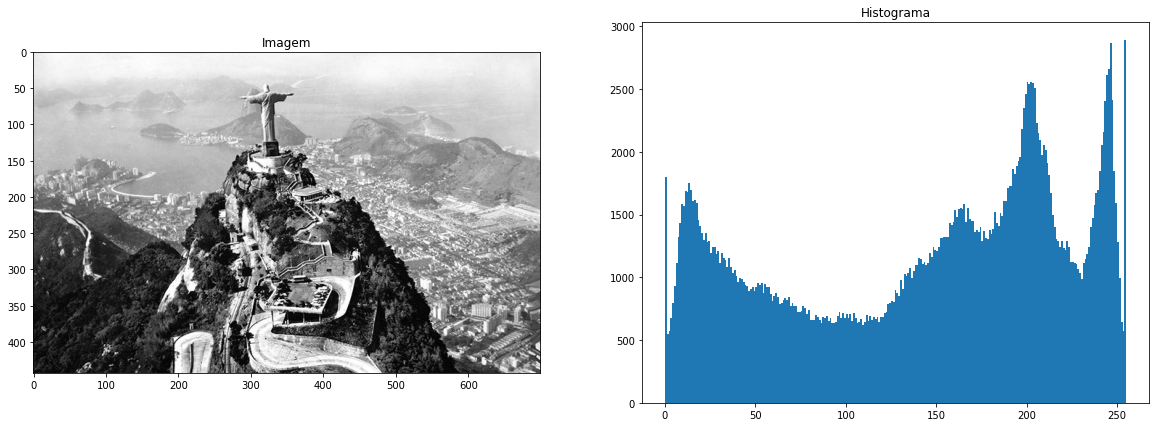

In [ ]:
def img_and_hist(image):
  """
  Plota uma imagem e seu histograma
  """
  plt.figure(figsize = (20,7))
  plt.subplot(1,2,1)
  plt.imshow(image, cmap = "gray")
  plt.title("Imagem")

  plt.subplot(1,2,2)
  plt.hist(image.ravel(), bins = 255)
  plt.title("Histograma");

# imagem de referência
ref = np.array(url_to_image("https://d3ugyf2ht6aenh.cloudfront.net/stores/363/165/products/rjacor012-fd89a9b9475876c52315278075057484-1024-1024.jpg"))
ref = cv2.cvtColor(ref, cv2.COLOR_RGB2GRAY)
img_and_hist(ref)

A imagem de referência possui bastante contraste, com pixels de intensidades variando entre 0 e 255.

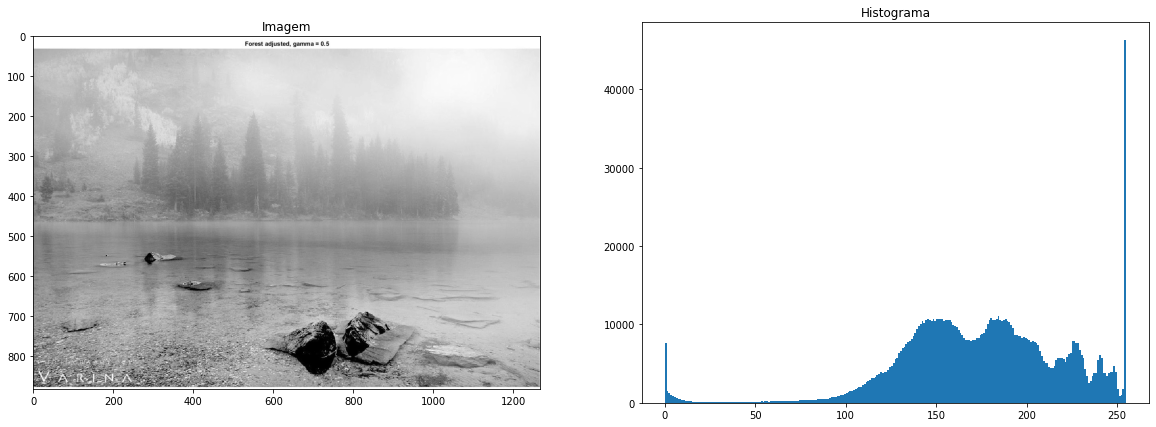

In [ ]:
# primeira imagem 
img1 = np.array(url_to_image("https://miro.medium.com/max/2536/1*95OZncSqm6wyAH_D5jcMOA.jpeg"))
img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
img_and_hist(img1)

Boa parte dos pixels dessa imagem apresentam intensidade entre 120 e 250 portanto o contraste é baixo, já os pixels estão concentrados na metade superior do espectro de intensidades possíveis.

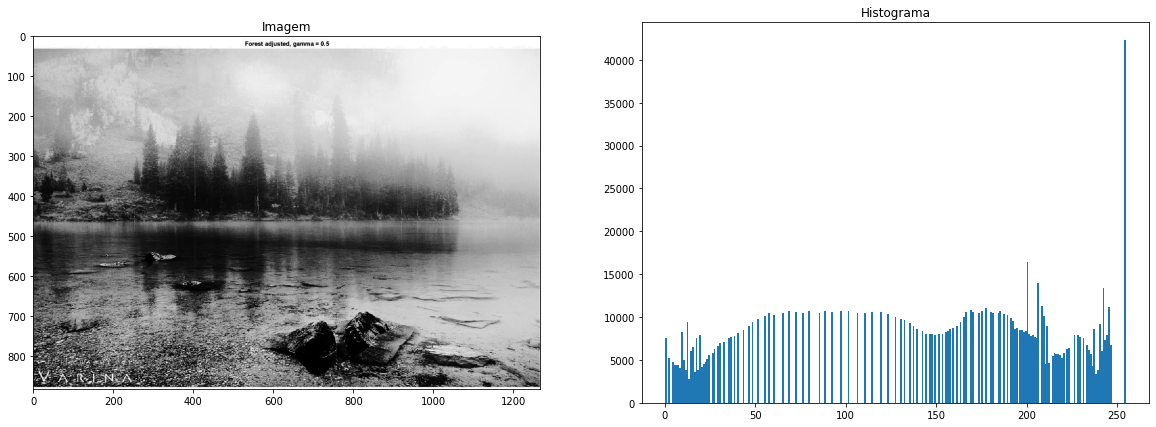

In [ ]:
# aplicando a especificação
new_img1 = histogram_specification(orig_img=img1, reference_img=ref)
img_and_hist(new_img1)

Ao aplicar a especificação, o contraste aumentou consideravelmente, com intensidades entre 0 e 255

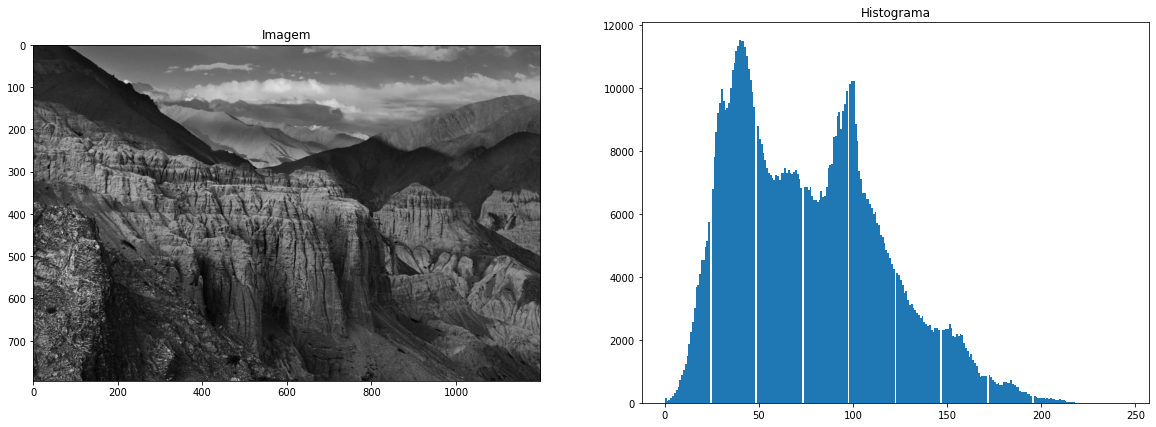

In [ ]:
# segunda imagem
img2 = np.array(url_to_image("https://photographylife.com/wp-content/uploads/2018/03/Low-Key-Landscape-Photography-9.jpg"))
img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
img_and_hist(img2)

Neste caso, boa parte dos pixels possuem intensidade entre 20  e 140. 

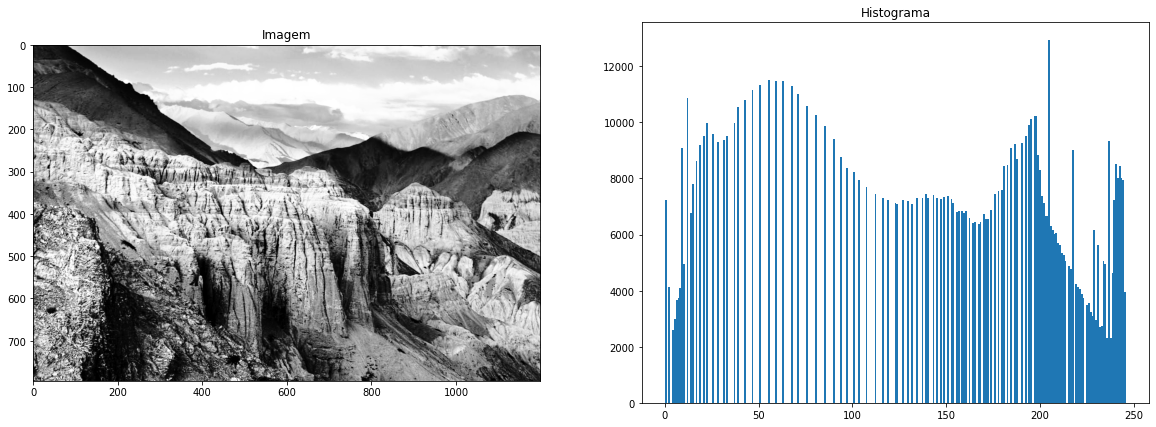

In [ ]:
# aplicando a especificação
new_img2 = histogram_specification(orig_img=img2, reference_img=ref)
img_and_hist(new_img2)

Novamente, o contraste aumentou bastante após a aplicação da especificação de histograma.